<center>
<img src="https://www.seekpng.com/png/full/113-1133172_digital-marketing-digital-marketing-clipart.png" width=600>
</center>
<div style="padding:20px; 
            color:#150d0a;
            margin:10px;
            font-size:220%;
            text-align:center;
            display:fill;
            border-radius:20px;
            border-width: 5px;
            border-style: solid;
            border-color: #150d0a;
            background-color:#eca912;
            overflow:hidden;
            font-weight:500">E-commerce User Segmentation</div>

### <font color='289C4E'>Table of contents<font><a class='anchor' id='top'></a>
1. [Explore,Clean and Format Data](#explore_clean_format)
2. [EDA to Understand the Data And Outlier Removal](#eda_to_understand_data)
3. [Feature Engineering and RFM analysis](#feture_engineering_and_rfm)
4. [KMeans to create segments](#kmeans_segments)

In [70]:
import pandas as pd 
import numpy as np 
import seaborn as sns 
import matplotlib.pyplot as plt 
import re
from datetime import datetime
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import scipy
sns.set_context("talk")
sns.despine()
sns.set_style("darkgrid")

<Figure size 640x480 with 0 Axes>

<h1 align="left"><font color='green'>1. Explore, Clean and Format Data</font></h1> <a class='anchor' id='explore_clean_format'></a>

In [6]:
df = pd.read_excel("Online Retail.xlsx")


In [7]:
# checking for null values
df.isnull().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

In [8]:
# if CustomerID is the entry looses the meaning so its better to drop columns where there are no customers 
df = df.dropna(subset=['CustomerID'])

In [9]:
# there are also 11 data points where description is missing 
df['Description'].str.contains("missing", flags=re.IGNORECASE).sum()

0

In [10]:
# there are also 82 data points where description is just a ?
df['Description'].str.contains("\?", flags=re.IGNORECASE).sum()

0

In [11]:
# Even though the description is missing we do have stockcode so I don't think we need to drop description , and Fortunately dropping null customers 
# took care of the missing descriptions

In [12]:
# we observe that quantity and Unit Price are negative 
df.describe()

,Quantity,UnitPrice,CustomerID
count,406829.000000,406829.000000,406829.000000
mean,12.061303,3.460471,15287.690570
std,248.693370,69.315162,1713.600303
min,-80995.000000,0.000000,12346.000000
25%,2.000000,1.250000,13953.000000
50%,5.000000,1.950000,15152.000000
75%,12.000000,3.750000,16791.000000
max,80995.000000,38970.000000,18287.000000


In [13]:
# there are 2515 items where Items are free😀 
df[df['UnitPrice'] == 0]['UnitPrice'].shape[0]

40

In [14]:
# Having Quantity negative makes no sense so lets drop columns where quantity is negative 
df = df[(df['Quantity'] > 0) & (df['UnitPrice'] > 0) ]

In [15]:
df['InvoiceNo'] = df['InvoiceNo'].astype(str)
df['StockCode'] = df['StockCode'].astype(str)

<div class="alert alert-block alert-info">
<b>Example:</b> The excel file was taking lot of time to load so I converted the file into parquet format for efficient processing
</div>

In [12]:
df.to_parquet('OnlineRetail.parquet')

<h1 align="left"><font color='green'>2. EDA to Understand the Data</font></h1> <a class='anchor' id='eda_to_understand_data'></a>

In [16]:
df = pd.read_parquet("OnlineRetail.parquet")

<h2 align="left"> <font color='gray'>Top 5 Customers who Spent Most Amount</font></h2>

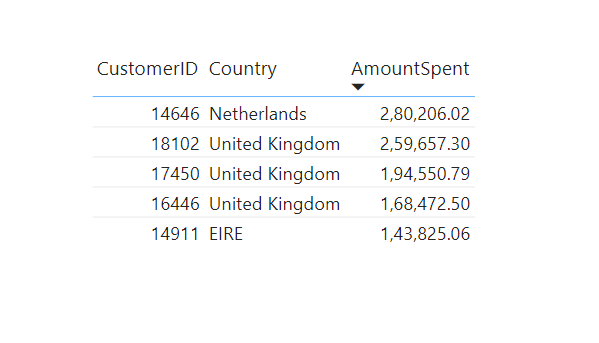

<h2 align="left"> <font color='gray'>Top 5 Customers With Most Orders</font></h2>

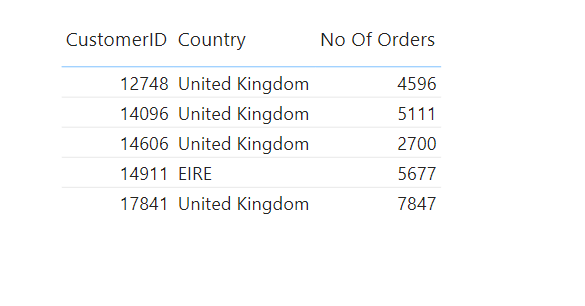

<h2 align="left"> <font color='gray'>Orders by Month</font></h2> 

- We observe Maximum number of Orders were placed November 2011 and least in December 2011 (December data might be incomplete)

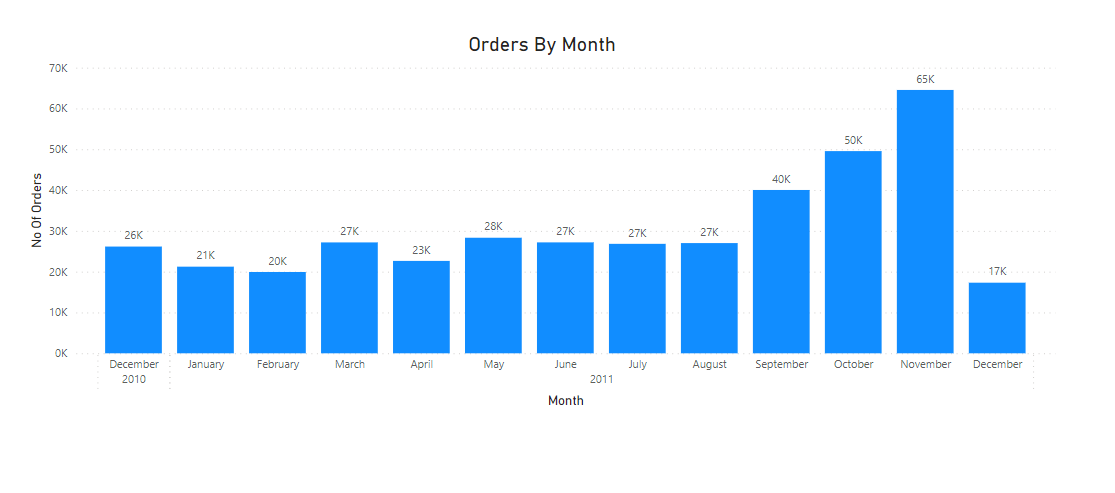

<h2 align="left"> <font color='gray'>Orders By Weekday</font></h2>
Most orders were placed on thursday and least on friday

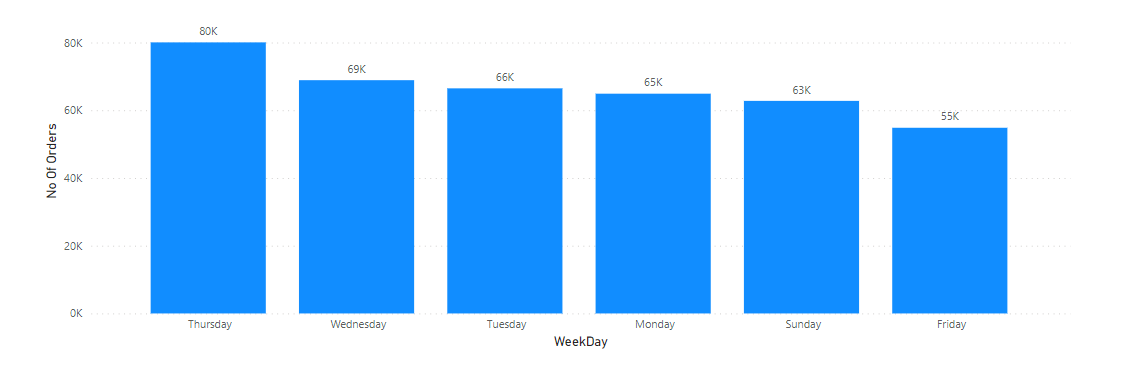

<h2 align="left"> <font color='gray'>Top 5 Customers With Most Orders</font></h2>

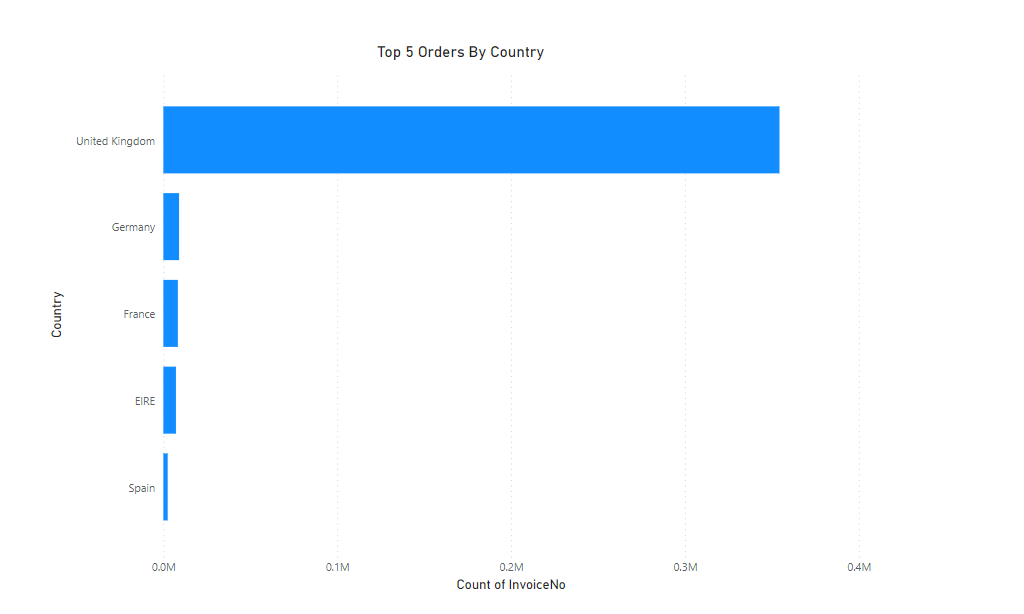


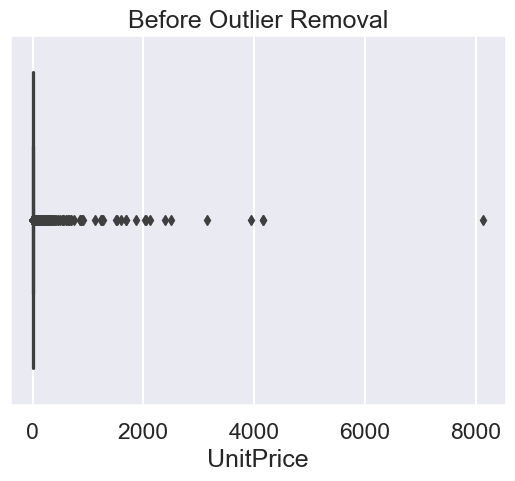

In [17]:
# plotting a box plot to find outliers in unit price
sns.boxplot(data = df, x = 'UnitPrice')
plt.title("Before Outlier Removal");

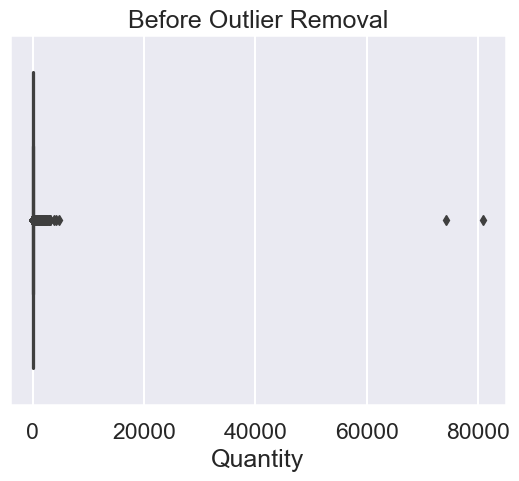

In [18]:
# plotting a box plot to find outliers in Quantity
sns.boxplot(data = df, x = 'Quantity')
plt.title("Before Outlier Removal");

In [19]:
# removing extreme values 
df = df[(df['UnitPrice']<6000) & (df['Quantity']<6000)]

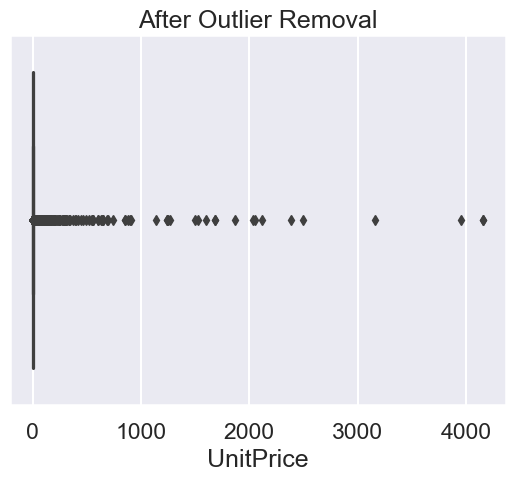

In [20]:
sns.boxplot(data = df, x = 'UnitPrice')
plt.title("After Outlier Removal");

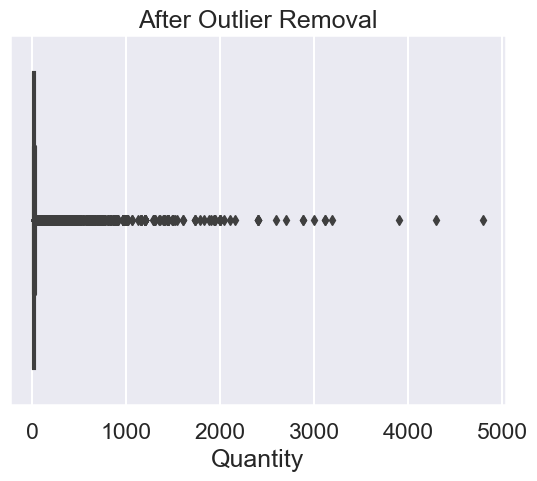

In [21]:
sns.boxplot(data = df, x = 'Quantity')
plt.title("After Outlier Removal");

<div class="alert alert-block alert-info">
<b>Info:</b> From the box plot we observe that lot of items are range between \$0-\$5
</div>

<h1 align="left"><font color='green'>3. Feature Engineering and RFM analysis</font></h1> <a class='anchor' id='feture_engineering_and_rfm'></a>

<h2>Performing RFM analysis</h2>
<ol>
  <li>
    <strong>Recency:</strong> How recently a customer has made a purchase
    <ul>
      <li>The more recently a customer had made a purchase the more likely they will continue to keep business and brand in mind.</li>
      <li>Such information can be used to get recent customers to visit the business and spend more. And efforts can be made to remind customers who are inactive to visit the website and make a transaction.</li>
    </ul>
  </li>
  <li>
    <strong>Frequency:</strong> How often a customer makes a purchase
    <ul>
      <li>The frequency of a customer’s transactions may be affected by factors such as the type of product, the price point for the purchase, and the need for replenishment or replacement.</li>
      <li>If the purchase cycle can be predicted—for example, when a customer needs to buy more groceries—marketing efforts may be directed toward reminding them to visit the business when staple items run low.</li>
    </ul>
  </li>
  <li>
    <strong>Monetary value:</strong> How much money a customer spends on purchases
    <ul>
      <li>Monetary value stems from how much the customer spends. A natural inclination is to put more emphasis on encouraging customers who spend the most money to continue to do so.</li>
      <li>While this can produce a better return on investment (ROI) in marketing and customer service, it also runs the risk of alienating customers who have been consistent but may not spend as much with each transaction.</li>
    </ul>
  </li>
</ol>
<p>This analysis will help us in segmenting customers into different homogenous groups so that we can engage with each group with different targeted manner.</p>

In [22]:
# creating amount feature 
df['Amount'] = df['Quantity'] * df['UnitPrice']

In [23]:
# the max date is 2011-12-09 lets take current_date as 2011-12-31
df['InvoiceDate'].max() 

Timestamp('2011-12-09 12:50:00')

In [24]:
current_date = datetime(2011,12,31)

In [25]:
group = df.groupby("CustomerID")
recency = group.apply(lambda x : (current_date - x['InvoiceDate'].max()).days)
monetary = df.groupby("CustomerID")['Amount'].sum()
frequency = df.groupby("CustomerID")['InvoiceNo'].count()

rmf_analysis_data_frame = pd.concat([recency, monetary, frequency], axis = 1)
rmf_analysis_data_frame = rmf_analysis_data_frame.rename(columns = {0:'Recency',"Amount":"Monetary","InvoiceNo":'Frequency'})

In [26]:
group = df.groupby("CustomerID") # Group the data in `df` by `CustomerID`
recency = group.apply(lambda x : (current_date - x['InvoiceDate'].max()).days) # Calculate recency for each group using a lambda function
monetary = df.groupby("CustomerID")['Amount'].sum() # Calculate monetary value for each customer
frequency = df.groupby("CustomerID")['InvoiceNo'].count() # Calculate frequency value for each customer
rmf_analysis_data_frame = pd.concat([recency, monetary, frequency], axis = 1) # Concatenate the `recency`, `monetary`, and `frequency` Series into a new DataFrame
rmf_analysis_data_frame = rmf_analysis_data_frame.rename(columns = {0:'Recency',"Amount":"Monetary","InvoiceNo":'Frequency'}) # Rename the columns of the new DataFrame```




In [27]:
# lower the recency is better
# 1 is the worst and 5 is the best 
rmf_analysis_data_frame['RecencyQuartile'] = pd.qcut(rmf_analysis_data_frame['Recency'],5,labels=[5,4,3,2,1]) # using qcut to make quartiles 
# higher the frequenct the better 
rmf_analysis_data_frame['FrequencyQuartile'] = pd.qcut(rmf_analysis_data_frame['Frequency'].rank(method = "first"),5,labels=[1,2,3,4,5])
# higher the money the better 
rmf_analysis_data_frame['MonetaryQuartile'] = pd.qcut(rmf_analysis_data_frame['Monetary'],5,labels=[1,2,3,4,5])

In [28]:
# Create a new column 'RMFSegment' by concatenating the quartile values of recency, frequency and monetary variables as strings
rmf_analysis_data_frame['RMFSegment'] = rmf_analysis_data_frame['RecencyQuartile'].astype(str) + rmf_analysis_data_frame['FrequencyQuartile'].astype(str) + rmf_analysis_data_frame['MonetaryQuartile'].astype(str)
# Create a new column 'RMFScore' by adding up the quartile values of recency, frequency and monetary variables as integers
rmf_analysis_data_frame['RMFScore'] = rmf_analysis_data_frame[['RecencyQuartile','FrequencyQuartile','MonetaryQuartile']].sum(axis = 1)

In [29]:
rmf_analysis_data_frame

,Recency,Monetary,Frequency,RecencyQuartile,FrequencyQuartile,MonetaryQuartile,RMFSegment,RMFScore
CustomerID,,,,,,,,
12347.0,23,4310.00,182,5,5,5,555,15
12348.0,96,1797.24,31,2,3,4,234,9
12349.0,39,1757.55,73,4,4,4,444,12
12350.0,331,334.40,17,1,2,2,122,5
12352.0,57,2506.04,85,3,4,5,345,12
...,...,...,...,...,...,...,...,...
18280.0,298,180.60,10,1,1,1,111,3
18281.0,201,80.82,7,1,1,1,111,3
18282.0,28,178.05,12,5,1,1,511,7


<h1 align="left"><font color='green'>4. KMeans to create segments</font></h1> <a class='anchor' id='kmeans_segments'></a>


<div class="alert alert-block alert-warning">  
<b>Distribution Fix:</b> KMeans Analysis We need to fix the distribution because the data is right skewed
</div>

1. To fix the distribution we will first add log transform followed by scaling the data 
     - Log transformation is a data transformation method that replaces each variable x with a log(x). It is often used to make highly skewed distributions less skewed, which can improve the interpretability and validity of statistical analyses
     - Scaling is used in k-means clustering because k-means algorithm is sensitive to the scale of the data and the initial cluster centers. If the data features have different scales, they will contribute unequally to the distance measure and the resulting clusters. StandardScaler helps to make the data scale-free and improve the clustering performanc


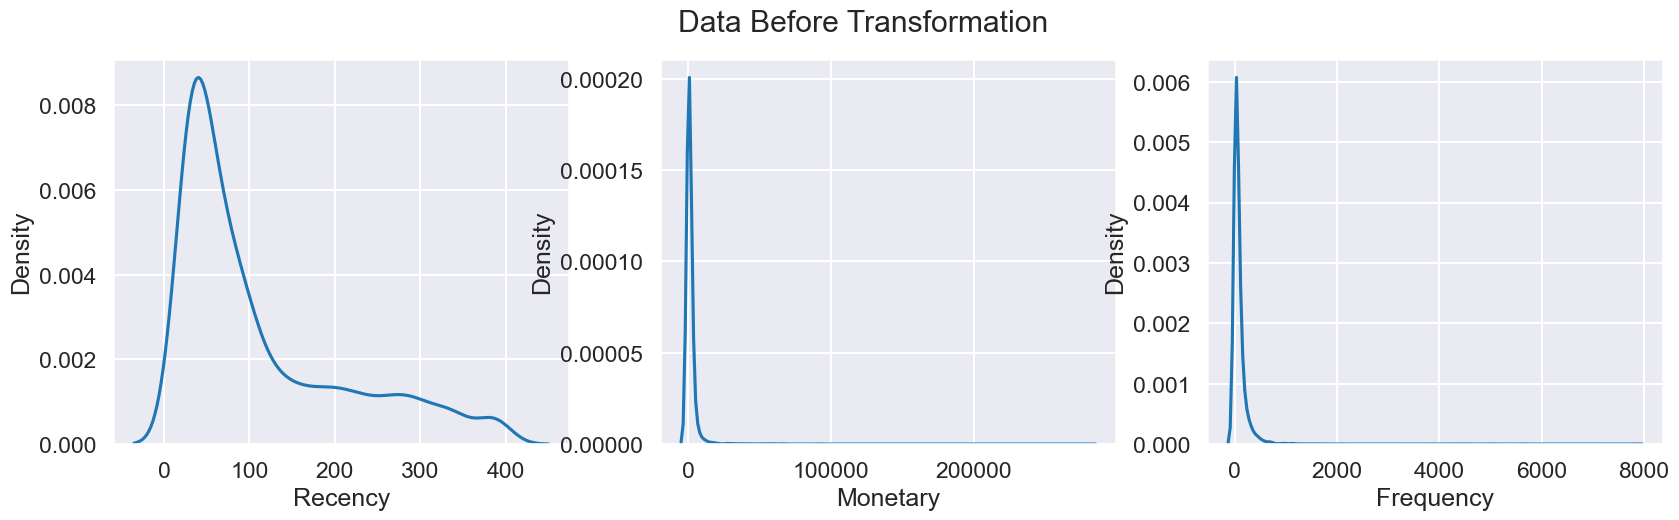

In [30]:
# Lets look at distribution 
fig, ax = plt.subplots(nrows = 1, ncols = 3, figsize = (20,5))
fig.suptitle("Data Before Transformation")

for a, col in zip(ax, rmf_analysis_data_frame.columns[:3]): 
    sns.kdeplot(x = col, data = rmf_analysis_data_frame, ax = a)
    

In [31]:
rmf_data = rmf_analysis_data_frame.iloc[:,:3].copy()
rmf_analysis_data_frame.iloc[:,:3] = np.log(rmf_analysis_data_frame.iloc[:,:3])

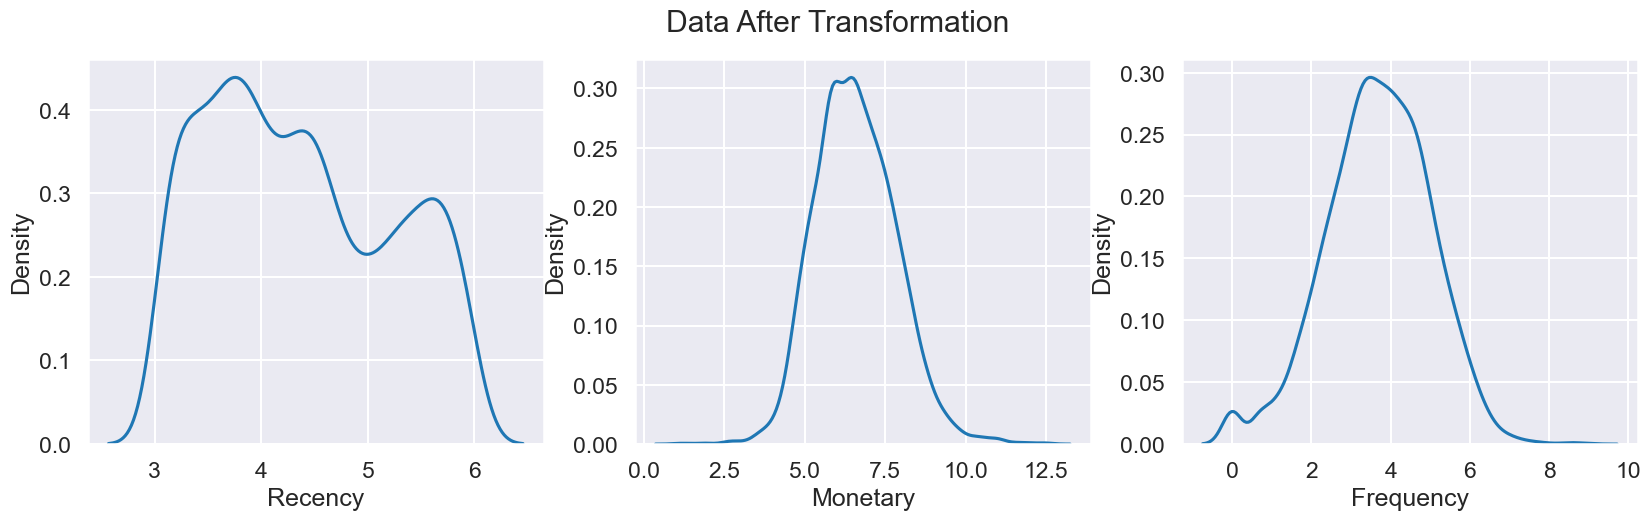

In [32]:
# Lets look at distribution we observe the data looks way better than previous 
fig, ax = plt.subplots(nrows = 1, ncols = 3, figsize = (20,5))
fig.suptitle("Data After Transformation")

for a, col in zip(ax, rmf_analysis_data_frame.columns[:3]): 
    sns.kdeplot(x = col, data = rmf_analysis_data_frame, ax = a)
    

In [33]:
#create an instance of StandardScaler
sc = StandardScaler()

#fit and transform the data frame with only the first three columns (Recency, Monetary, Frequency)
rmf_data_scaled = sc.fit_transform(rmf_analysis_data_frame.iloc[:,:3])

#convert the scaled array into a data frame with the same column names as the original data frame
rmf_data_scaled = pd.DataFrame(rmf_data_scaled, columns = rmf_data.columns)

In [34]:
# save the model 
import pickle 
with open("savedmodels/standardscaler.pkl", 'wb') as f: 
    pickle.dump(sc,f)

<p>Let us use elbow method to get optimal clusters using silhouette score.</p> <p>The silhouette score is a metric that measures how well a data point fits into its assigned cluster, based on the distance to other points in the same cluster and the nearest neighboring cluster . It ranges from -1 to 1, where a higher value indicates a better fit. The silhouette score can be used to evaluate the quality of k-means clustering and to choose the optimal number of clusters.</p> <p>The value of k that gives me the highest silhouette score is the best one for the data.</p>

In [35]:
# Create an empty list to store the silhouette scores for different values of k
scores = [] 

# Iterate over a range of values for k, from 2 to 10
for k in range(2, 11): 
    # Create a KMeans clustering object with k clusters
    kmeans = KMeans(n_clusters=k) 
    # Fit the KMeans object to the scaled data
    kmeans.fit(rmf_data_scaled)
    # Get the cluster labels for each data point
    labels = kmeans.labels_ 
    # Calculate the silhouette score for the clustering with k clusters
    score = silhouette_score(rmf_data_scaled, labels, metric="euclidean")
    # Add the silhouette score to the list of scores
    scores.append(score)


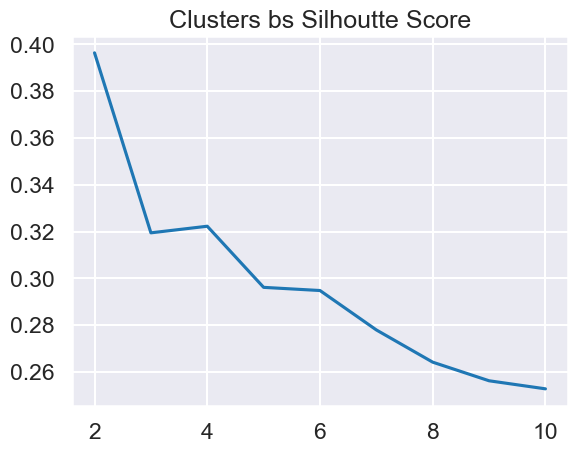

In [36]:
sns.lineplot(x = list(range(2,11)), y = scores,)
plt.title("Clusters bs Silhoutte Score");

<div class="alert alert-block alert-info">
<b>Choosing K:</b> The Silhouette Score reaches its global maximum at the optimal k. This should ideally appear as a peak in the Silhouette Value-versus-k plot. in this case k = 4
</div>

In [37]:
# Set the number of clusters to 4
k = 4
# Create a KMeans object with k clusters and a random state of 42
kmeans = KMeans(n_clusters=k, random_state=42) 
# Fit the KMeans object to the scaled rmf data
kmeans.fit(rmf_data_scaled)
# Get the cluster labels for each data point
labels = kmeans.labels_
# Add the cluster labels as a new column to the rmf analysis data frame
rmf_analysis_data_frame['Clusters'] = labels
# Add the cluster labels as a new column to the original rmf data
rmf_data['Clusters'] = labels

In [38]:
# save the kmeans 
with open("savedmodels/kmeans.pkl", 'wb') as f: 
    pickle.dump(kmeans,f)

### Relative importance of segment attributes
* Useful technique to identify relative importance of each segment's attribut

In [41]:
cluster_average = rmf_analysis_data_frame.groupby(['Clusters']).mean().drop(columns = "RMFScore")
population_average = rmf_data.drop(columns = "Clusters").mean()

C:\Users\siddharth_black_pred\AppData\Local\Temp\ipykernel_16544\2860939693.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  cluster_average = rmf_analysis_data_frame.groupby(['Clusters']).mean().drop(columns = "RMFScore")


In [42]:
population_average

Recency       113.053032
Monetary     1996.221341
Frequency      91.741065
dtype: float64

In [43]:
cluster_average

,Recency,Monetary,Frequency
Clusters,,,
0,3.633140,7.922714,5.057023
1,5.398041,5.230751,2.120876
2,5.004057,6.704588,3.834830
3,3.867067,5.993261,3.162719


In [44]:
rmf_data['Clusters'] = kmeans.labels_
relative_importance = (cluster_average / population_average - 1).round(2)

The relative importance of variables in K-means clustering indicates how much each variable contributes to the overall clustering solution. It can help you understand which variables are most important in differentiating between the clusters and identifying patterns in your data.

A higher relative importance score for a variable means that it has a larger impact on the clustering solution, while a lower score indicates that it has a smaller impact.

<AxesSubplot:ylabel='Clusters'>

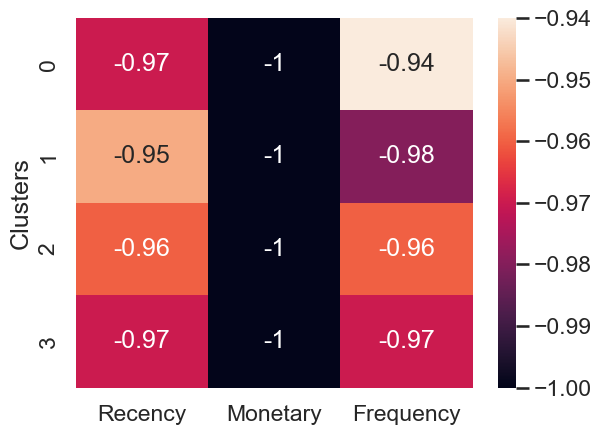

In [45]:
sns.heatmap(data = relative_importance, annot=True)

In [48]:
rmf_analysis_data_frame

,Recency,Monetary,Frequency,RecencyQuartile,FrequencyQuartile,MonetaryQuartile,RMFSegment,RMFScore,Clusters
CustomerID,,,,,,,,,
12347.0,3.135494,8.368693,5.204007,5,5,5,555,15,0
12348.0,4.564348,7.494007,3.433987,2,3,4,234,9,2
12349.0,3.663562,7.471676,4.290459,4,4,4,444,12,0
12350.0,5.802118,5.812338,2.833213,1,2,2,122,5,1
12352.0,4.043051,7.826459,4.442651,3,4,5,345,12,0
...,...,...,...,...,...,...,...,...,...
18280.0,5.697093,5.196285,2.302585,1,1,1,111,3,1
18281.0,5.303305,4.392224,1.945910,1,1,1,111,3,1
18282.0,3.332205,5.182064,2.484907,5,1,1,511,7,3


Text(0.5, 1.0, 'Customers With Low Recency usually tend to have high frequency')

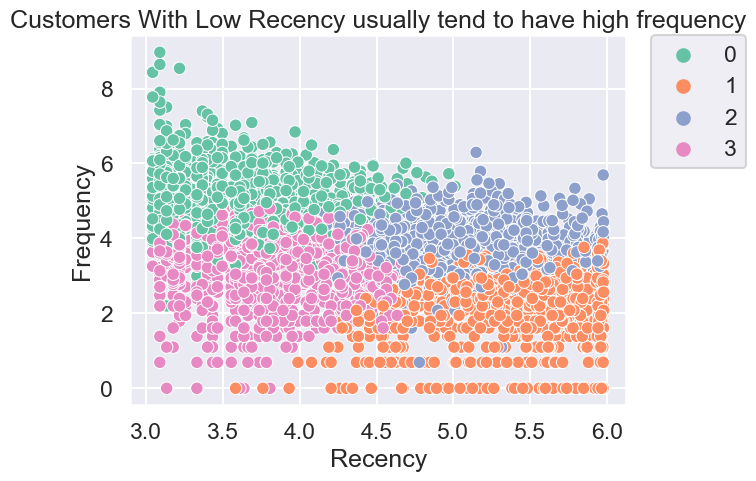

In [49]:
sns.scatterplot(x = rmf_analysis_data_frame['Recency'], y = rmf_analysis_data_frame['Frequency'], hue = rmf_analysis_data_frame['Clusters'], palette='Set2');
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.);
plt.title("Customers With Low Recency usually tend to have high frequency")

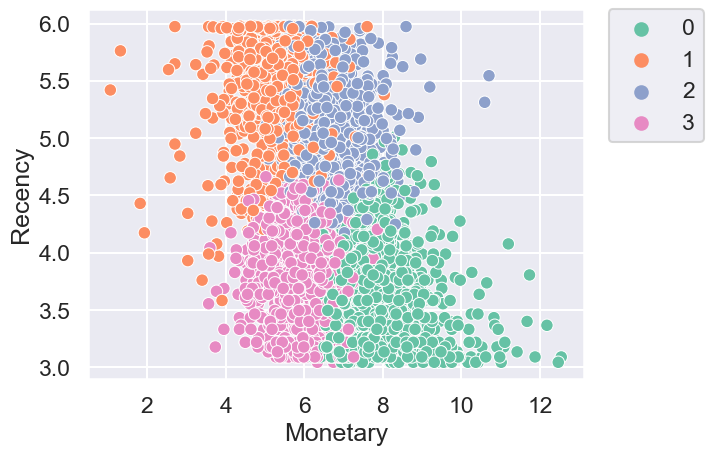

In [50]:
sns.scatterplot(x = rmf_analysis_data_frame['Monetary'], y = rmf_analysis_data_frame['Recency'], hue = rmf_analysis_data_frame['Clusters'], palette="Set2");
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

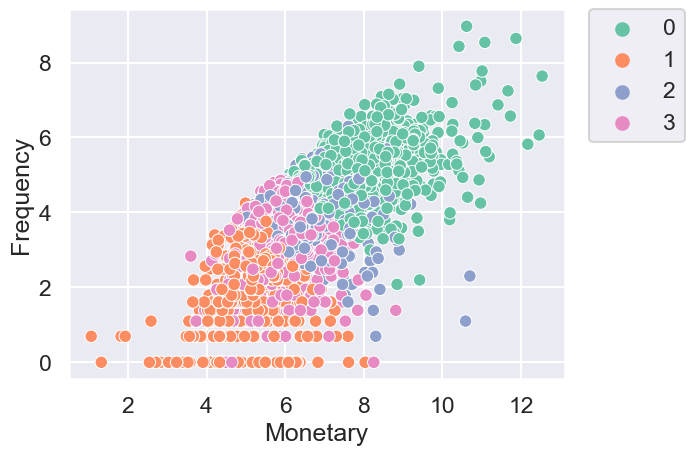

In [51]:
sns.scatterplot(x = rmf_analysis_data_frame['Monetary'], y = rmf_analysis_data_frame['Frequency'], hue = rmf_analysis_data_frame['Clusters'], palette="Set2");
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

In [52]:
rmf_data.groupby("Clusters").agg({"Recency":"mean", "Monetary":"mean","Frequency":"mean"})

,Recency,Monetary,Frequency
Clusters,,,
0,41.561696,5133.966495,223.846329
1,241.854214,240.215535,11.562642
2,166.526047,1101.664466,56.840654
3,51.795513,505.783833,31.389991


### Analysing The Clusters 
1. Cluster 0 - are best customers with low recency high monetary and high frequency - Platinum Customers
2. Cluster 2 - represents customer with relative low Recency High Monetary and Somewhat high frequency - Gold Customers 
3. Cluster 3 - Silver Customers
4. Cluster 1 - Bronze Customer 

### RMF Score Analysis

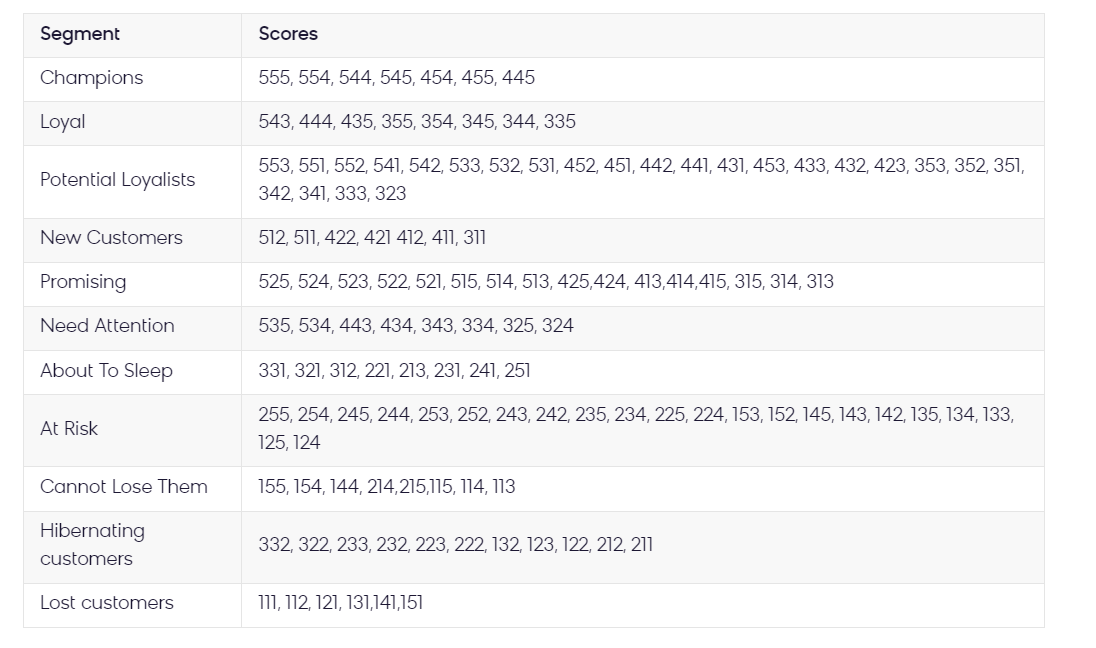

<ul>
<li><strong>Hibernating</strong>: These are customers who have not purchased for a long time, have low frequency and low monetary value. They are likely to be inactive or lost customers who need reactivation campaigns or special offers to win them back.</li>
<li><strong>At risk</strong>: These are customers who have not purchased recently, but have high frequency and high monetary value. They are likely to be loyal customers who are losing interest or switching to competitors. They need attention and retention campaigns to remind them of the value proposition and benefits of the brand.</li>
<li><strong>Can’t lose them</strong>: These are customers who have not purchased recently, have high frequency and very high monetary value. They are likely to be the most valuable customers who are at risk of churning. They need personalized and exclusive offers, loyalty programs, and VIP treatment to retain them and increase their satisfaction.</li>
<li><strong>About to sleep</strong>: These are customers who have not purchased recently, have low frequency and low monetary value. They are likely to be occasional customers who are becoming inactive or indifferent. They need re-engagement campaigns, feedback surveys, and product recommendations to revive their interest and loyalty.</li>
<li><strong>Need attention</strong>: These are customers who have purchased recently, have average frequency and average monetary value. They are likely to be potential loyal customers who need some attention and encouragement to increase their engagement and spending. They need cross-selling and upselling campaigns, loyalty programs, and product reviews to motivate them to buy more frequently and spend more.</li>
<li><strong>Loyal customers</strong>: These are customers who have purchased recently, have high frequency and high monetary value. They are likely to be loyal and satisfied customers who generate consistent revenue and referrals. They need appreciation and recognition campaigns, loyalty rewards, and exclusive offers to maintain their loyalty and advocacy.</li>
    <li><strong>Promising</strong>: These are customers who have purchased recently, have low frequency and low monetary value. They are likely to be new or recent customers who have not yet established a purchase pattern or preference. They need welcome campaigns, onboarding programs, and product education to increase their awareness and trust in the brand.</li>
<li><strong>New customers</strong>: These are customers who have purchased very recently, have very low frequency and low monetary value. They are likely to be first-time buyers who have not yet developed a relationship with the brand. They need thank you campaigns, follow-up messages, and social proof to increase their retention and satisfaction.</li>
<li><strong>Potential loyalists</strong>: These are customers who have purchased recently, have high frequency and low monetary value. They are likely to be frequent but low-spending customers who have the potential to become loyal and valuable customers. They need upselling and cross-selling campaigns, free trials, and discounts to increase their spending and loyalty.</li>
<li><strong>Champions</strong>: These are customers who have purchased very recently, have very high frequency and very high monetary value. They are likely to be the best customers who are loyal, engaged, and profitable. They need referral programs, co-creation opportunities, and community building to leverage their advocacy and influence.</li>
</ul>

In [54]:
segmentation_map = {
    r'[1-2][1-2]': 'hibernating',
    r'[1-2][3-4]': 'at_Risk',
    r'[1-2]5': 'cant_loose',
    r'3[1-2]': 'about_to_sleep',
    r'33': 'need_attention',
    r'[3-4][4-5]': 'loyal_customers',
    r'41': 'promising',
    r'51': 'new_customers',
    r'[4-5][2-3]': 'potential_loyalists',
    r'5[4-5]': 'champions'
}

cluster_map = {
    0: "Platinum", 
    2: "Gold",
    3: "Silver",
    1: "Bronze"
}

In [56]:
rmf_analysis_data_frame['Segments'] = rmf_analysis_data_frame['RMFSegment'].str[:2].replace(segmentation_map, regex=True)
# Assign cluster segments to the rmf_analysis_data_frame based on the Clusters column and the cluster_map dictionary
rmf_analysis_data_frame['ClusterSegments'] = rmf_analysis_data_frame['Clusters'].replace(cluster_map)

In [57]:
rmf_analysis_data_frame

,Recency,Monetary,Frequency,RecencyQuartile,FrequencyQuartile,MonetaryQuartile,RMFSegment,RMFScore,Clusters,Segments,ClusterSegments
CustomerID,,,,,,,,,,,
12347.0,3.135494,8.368693,5.204007,5,5,5,555,15,0,champions,Platinum
12348.0,4.564348,7.494007,3.433987,2,3,4,234,9,2,at_Risk,Gold
12349.0,3.663562,7.471676,4.290459,4,4,4,444,12,0,loyal_customers,Platinum
12350.0,5.802118,5.812338,2.833213,1,2,2,122,5,1,hibernating,Bronze
12352.0,4.043051,7.826459,4.442651,3,4,5,345,12,0,loyal_customers,Platinum
...,...,...,...,...,...,...,...,...,...,...,...
18280.0,5.697093,5.196285,2.302585,1,1,1,111,3,1,hibernating,Bronze
18281.0,5.303305,4.392224,1.945910,1,1,1,111,3,1,hibernating,Bronze
18282.0,3.332205,5.182064,2.484907,5,1,1,511,7,3,new_customers,Silver


In [46]:
rmf_data = rmf_data.drop(columns = 'Clusters')
# Rename the columns of the rmf_data dataframe to URecency, UMonetary and UFrequency
rmf_data.columns = ['URecency','UMonetary','UFrequency']
# Concatenate the rmf_data and rmf_analysis_data_frame dataframes along the columns axis
features_dataset = pd.concat([rmf_data, rmf_analysis_data_frame], axis = 1)
# Save the features_dataset dataframe as a csv file
features_dataset.to_csv("FeaturesDataset.csv")

In [61]:
rmf_analysis_data_frame

,Recency,Monetary,Frequency,RecencyQuartile,FrequencyQuartile,MonetaryQuartile,RMFSegment,RMFScore,Clusters,Segments,ClusterSegments
CustomerID,,,,,,,,,,,
12347.0,3.135494,8.368693,5.204007,5,5,5,555,15,0,champions,Platinum
12348.0,4.564348,7.494007,3.433987,2,3,4,234,9,2,at_Risk,Gold
12349.0,3.663562,7.471676,4.290459,4,4,4,444,12,0,loyal_customers,Platinum
12350.0,5.802118,5.812338,2.833213,1,2,2,122,5,1,hibernating,Bronze
12352.0,4.043051,7.826459,4.442651,3,4,5,345,12,0,loyal_customers,Platinum
...,...,...,...,...,...,...,...,...,...,...,...
18280.0,5.697093,5.196285,2.302585,1,1,1,111,3,1,hibernating,Bronze
18281.0,5.303305,4.392224,1.945910,1,1,1,111,3,1,hibernating,Bronze
18282.0,3.332205,5.182064,2.484907,5,1,1,511,7,3,new_customers,Silver


<p>I feel like there is a relationship between the derived Segments and ClusterSegments instead of doing manual analysis I am using chi-square test to check for the relationship if there 
if a significant relationship we do not need to analyse the clusters seprately </p>
<p>Null Hypothesis (H0): There is no substantial relationship between the two variables (in case of independence test), or there is no difference in variable distribution (in case of goodness of fit). </p>
<p>Alternative Hypothesis (H1): There is a substantial relationship between variables (in case of independence test) or a significant variation in variable distribution (in case of goodness of fit).</p>

In [67]:
ci_table = pd.crosstab(rmf_analysis_data_frame['Segments'],rmf_analysis_data_frame['ClusterSegments'])

In [72]:
chi2_stat, p, dof, expected = scipy.stats.chi2_contingency(ci_table)

In [75]:
p # p is less than 0.05 there is a substantial relationship between variables 

0.0